In [54]:
import os
import pandas as pd
%matplotlib inline

In [55]:
os.chdir(r'.//')

import sqlite3 # sqlite3相当于轻量版，更多功能可使用SQLAlchemy

con = sqlite3.connect(':memory:') # 数据库连接

card=pd.read_csv(r"card.csv",encoding="gbk")
disp=pd.read_csv(r"disp.csv",encoding="gbk")
clients=pd.read_csv(r"clients.csv",encoding="gbk")

card.to_sql('card', con)
disp.to_sql('disp', con)
clients.to_sql('clients', con)

In [56]:
car_sql='''
select a.*,c.sex,c.birth_date,c.district_id
  from card as a
  left join disp as b on a.disp_id=b.disp_id
  left join clients as c on b.client_id=c.client_id
  where b.type="所有者"
'''
card_t=pd.read_sql(car_sql, con)

In [69]:
card_t.head()

,index,card_id,disp_id,issued,type,sex,birth_date,district_id
0,777,1,9,1998-10-16,金卡,男,1935-10-16,60
1,508,2,19,1998-03-13,普通卡,男,1942-12-28,47
2,64,3,41,1995-09-03,金卡,男,1968-08-27,22
3,840,4,42,1998-11-26,普通卡,男,1935-08-17,68
4,40,5,51,1995-04-24,青年卡,女,1979-12-02,36


In [67]:
c1 = pd.merge(left = card, right= disp, on='disp_id')
c1.head()

,card_id,disp_id,issued,type_x,client_id,account_id,type_y
0,1005,9285,1993-11-07,普通卡,9593,7753,所有者
1,104,588,1994-01-19,普通卡,588,489,所有者
2,747,4915,1994-02-05,普通卡,4915,4078,所有者
3,70,439,1994-02-08,普通卡,439,361,所有者
4,577,3687,1994-02-15,普通卡,3687,3050,所有者


In [71]:
c2 = pd.merge(left = c1, right = clients, on='client_id')
c2.head()
c2 = c2[c2.type_y == '所有者']
c2.head()

,card_id,disp_id,issued,type_x,client_id,account_id,type_y,sex,birth_date,district_id
0,1005,9285,1993-11-07,普通卡,9593,7753,所有者,女,1968-01-28,74
1,104,588,1994-01-19,普通卡,588,489,所有者,女,1960-10-20,61
2,747,4915,1994-02-05,普通卡,4915,4078,所有者,男,1963-07-19,40
3,70,439,1994-02-08,普通卡,439,361,所有者,女,1968-09-12,51
4,577,3687,1994-02-15,普通卡,3687,3050,所有者,男,1972-02-06,49


In [38]:
transf1 = {'金卡':'gold', '普通卡':'normal', '青年卡':'young'}
card_t.type = card_t.type.apply(lambda x: transf1[x])
transf2 = {'男':'male', '女':'female'}
card_t.sex = card_t.sex.apply(lambda x: transf2[x])

In [40]:
card_t.head()

,index,card_id,disp_id,issued,type,sex,birth_date,district_id
0,777,1,9,1998-10-16,gold,male,1935-10-16,60
1,508,2,19,1998-03-13,normal,male,1942-12-28,47
2,64,3,41,1995-09-03,gold,male,1968-08-27,22
3,840,4,42,1998-11-26,normal,male,1935-08-17,68
4,40,5,51,1995-04-24,young,female,1979-12-02,36


In [41]:
from pylab import mpl
mpl.rcParams['axes.unicode_minus'] = False # 解决保存图像是负号'-'显示为方块的问题

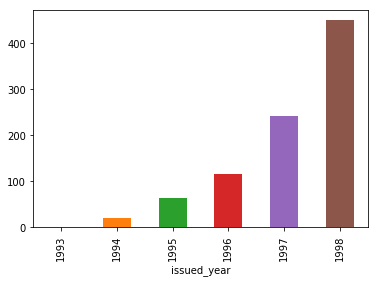

In [72]:
#%%#1、发卡趋势
#总体发卡趋势
from  datetime  import  *  
card_t['issued_date']=pd.to_datetime(card_t['issued'])
card_t['issued_year']=card_t['issued_date'].map(lambda x:x.year)

card_t.card_id.groupby(card_t['issued_year']).count().plot(kind="bar")

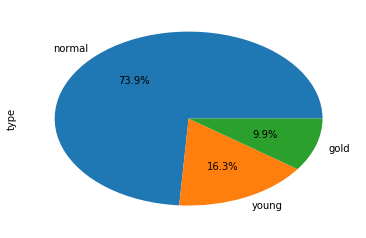

In [43]:
#%%#2、不同卡的分布
card_t.type.value_counts().plot(kind="pie",autopct='%.1f%%')

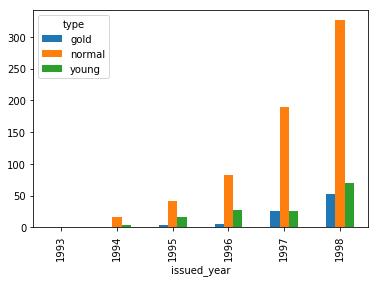

In [44]:
#%%#分类型发卡趋势
pd.crosstab(card_t.issued_year,card_t.type).plot(kind = 'bar')

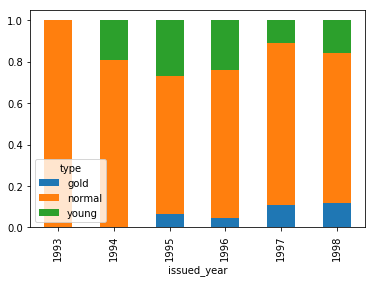

In [45]:
#%%#分类型发卡占比
t1=pd.crosstab(card_t.issued_year,card_t.type)
t1["sum1"]=t1.sum(1)
t2=t1.div(t1.sum1,axis = 0)
t2.drop("sum1",1).plot(kind = 'bar',stacked= True)

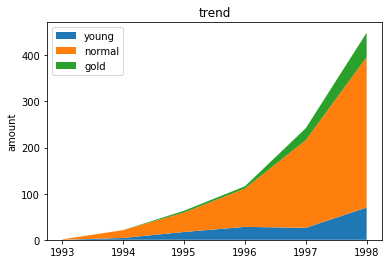

In [46]:
#%%面积图
import matplotlib.pyplot as plt
labels=["young","normal","gold"]
y1=t1.loc[:,"young"].astype('int')
y2=t1.loc[:,"normal"].astype('int')
y3=t1.loc[:,"gold"].astype('int')
x=t1.index.astype('int')
plt.stackplot(x,y1,y2,y3,labels = labels)
plt.title('trend')
plt.ylabel('amount')
plt.legend(loc = 'upper left')
plt.show()

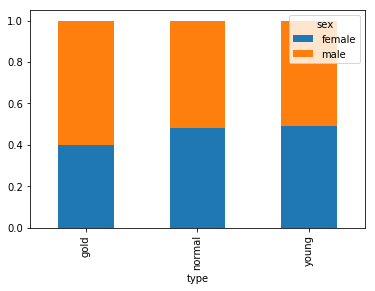

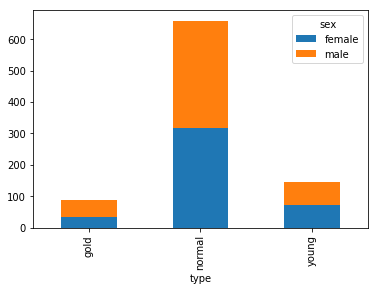

In [53]:
#%%#3、不同持卡人的性别对比
sub_sch=pd.crosstab(card_t.type,card_t.sex)
sub_sch.div(sub_sch.sum(1),axis = 0).plot(kind = 'bar',stacked= True)
sub_sch.plot(kind = 'bar',stacked= True)

In [50]:
sub_sch

sex,female,male
type,,
gold,35,53
normal,317,342
young,71,74


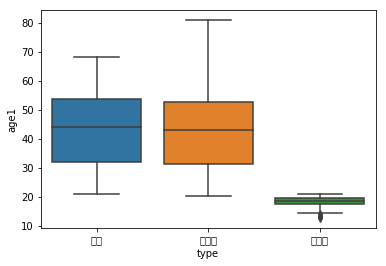

<Figure size 432x288 with 0 Axes>

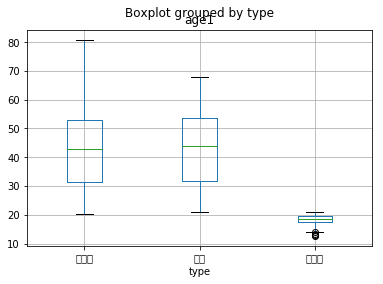

In [20]:
#%%4、不同类型卡的持卡人在办卡时的平均年龄对比
import seaborn as sns
import time
card_t['age']=(pd.to_datetime(card_t['issued'])-pd.to_datetime(card_t['birth_date']))

card_t['age1']=card_t['age'].map(lambda x:x.days/365)
sns.boxplot(x = 'type', y = 'age1', data = card_t)
plt.figure()
card_t.boxplot(column = 'age1', by='type')

In [13]:
#%%5、不同类型卡的持卡人在办卡前一年内的平均帐户余额对比
trans=pd.read_csv(r"trans.csv",encoding="gbk")

trans.to_sql('trans', con)
#%%
card_t.to_sql('card_t', con)

/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/anaconda3/lib/python3.6/site-packages/pandas/io/sql.py:450: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  chunksize=chunksize, dtype=dtype)


In [14]:
#%%
car_sql='''
select a.card_id,a.issued,a.type,c.type as t_type,c.amount,c.balance,c.date as t_date
  from card as a
  left join disp as b on a.disp_id=b.disp_id
  left join trans as c on b.account_id=c.account_id
  where b.type="所有者"
  order by a.card_id,c.date
'''

card_t2=pd.read_sql(car_sql, con)
#%%
card_t2['issued']=pd.to_datetime(card_t2['issued'])
card_t2['t_date']=pd.to_datetime(card_t2['t_date'])

In [15]:
# ## 将对账户余额进行清洗
import datetime
card_t2['balance2'] = card_t2['balance'].map(
    lambda x: int(''.join(x[1:].split(','))))
card_t2['amount2'] = card_t2['amount'].map(
    lambda x: int(''.join(x[1:].split(','))))

card_t2.head()
card_t3 = card_t2[card_t2.issued>card_t2.t_date][
    card_t2.issued<card_t2.t_date+datetime.timedelta(days=365)]

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()


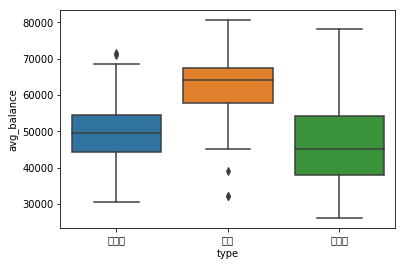

In [16]:
#card_t3["avg_balance"] = card_t3.groupby('card_id')['balance2'].mean()
card_t4=card_t3.groupby(['type','card_id'])['balance2'].agg([('avg_balance','mean')])
card_t4.to_sql('card_t4', con)
#%%
card_t5=card_t4.reset_index()
#card_t5=pd.read_sql('select * from card_t4', con)
sns.boxplot(x = 'type', y = 'avg_balance', data = card_t5)

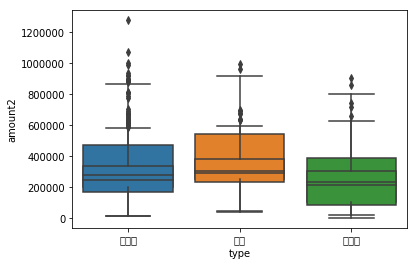

In [17]:
#%%6、不同类型卡的持卡人在办卡前一年内的平均收入对比
type_dict = {'借':'out','贷':'income'}
card_t3['type1'] = card_t3.t_type.map(type_dict)
card_t6= card_t3.groupby(['type','card_id','type1'])[['amount2']].sum()
card_t6.head()
card_t6.to_sql('card_t6', con)
#%%
card_t7=card_t6.reset_index()
#card_t7=pd.read_sql('select * from card_t6', con)
card_t7.to_sql('card_t7', con)
card_t8=pd.read_sql('select * from card_t7 where type1="income"', con)
# In[13]:
sns.boxplot(x = 'type', y = 'amount2', data = card_t8)

#%%
card_t9=pd.read_sql('select * from card_t7 where type1="out"', con)
# In[13]:
sns.boxplot(x = 'type', y = 'amount2', data = card_t9)